In [2]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact

anim_tag = "cat_rotation_90:latest"
animation = AnimationArtifact.from_wandb_artifact_tag(anim_tag, download=True)

frames = animation.frame_nums(5)
cameras = animation.cameras(frames)
meshes = animation.load_frames(frames)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   2 of 2 files downloaded.  


In [8]:
import torch
from diffusers import ControlNetModel, DPMSolverMultistepScheduler
from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline
from text3d2video.ipython_utils import display_ims

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

dtype = torch.float16
device = torch.device("cuda")

controlnet = ControlNetModel.from_pretrained(
    controlnet_repo, torch_dtype=torch.float16
).to(device)

pipe = ControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

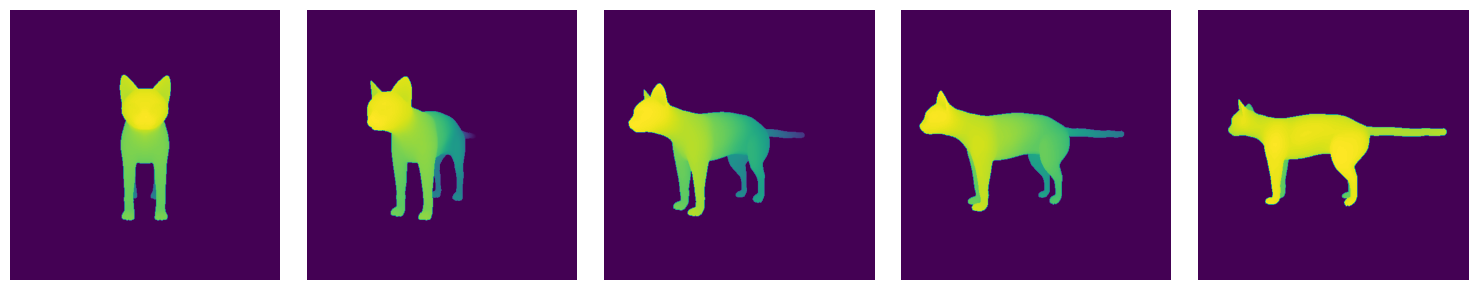

In [4]:
from text3d2video.rendering import render_depth_map

depth_maps = render_depth_map(meshes, cameras)
display_ims(depth_maps, 3)

100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


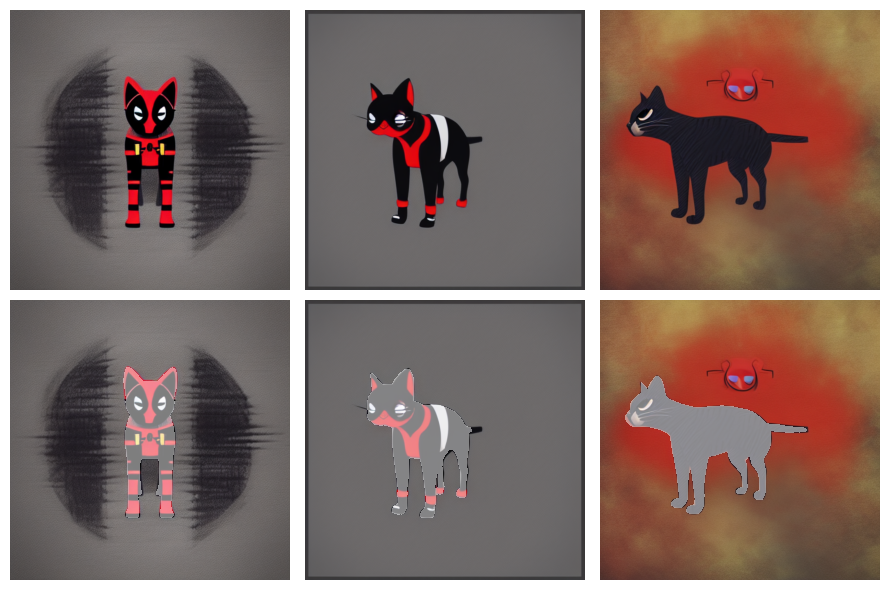

In [14]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from text3d2video.attn_processor import MultiFrameAttnProcessor, SaveConfig


def plot_images_and_depth(images, depths, scale=3, alpha=0.5):
    n_ims = len(images)
    transparent_cmap = ListedColormap(["none"] + ["white"] * 5)

    fig, axs = plt.subplots(2, n_ims, figsize=(scale * n_ims, 2 * scale))

    for i in range(n_ims):
        ax_im = axs[0, i]
        ax_im_depth = axs[1, i]
        ax_im.imshow(images[i])
        ax_im_depth.imshow(images[i])
        ax_im_depth.imshow(depths[i], cmap=transparent_cmap, alpha=alpha)
        ax_im.axis("off")
        ax_im_depth.axis("off")

    plt.tight_layout()


attn_processor = MultiFrameAttnProcessor(pipe.unet)


def pre_step(t, i):
    attn_processor.cur_timestep = t
    attn_processor.cur_timestep_idx = i


save_cfg = SaveConfig()
save_cfg.save_steps = []
save_cfg.module_pahts = []
attn_processor.save_cfg = save_cfg

pipe.pre_step_callback = pre_step
# pipe.unet.set_attn_processor(attn_processor)

attn_processor.attend_to_self = False
attn_processor.target_frame_indices = [0,1,2,3,4]

gen = torch.Generator(device=device)
gen.manual_seed(2)

depth_maps = depth_maps[0:3]

prompt = "Deadpool Cat"
n = len(depth_maps)
images = pipe(
    [prompt] * n,
    depth_maps,
    guess_mode=False,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1,
    generator=gen,
)

plot_images_and_depth(images, depth_maps, scale=3)